# Libraries and Settings

In [1]:
import warnings
import numpy as np
import pandas as pd
import joblib



import seaborn as sns
import missingno as msno
from matplotlib import pyplot as plt
import plotly.express as px



from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report,f1_score,recall_score,roc_auc_score, roc_curve


from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler


from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier






pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv

# First observation / EDA

In [2]:
df_= pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = df_.copy()


df.columns = [col.upper() for col in df.columns]
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
CUSTOMERID           object
GENDER               object
SENIORCITIZEN         int64
PARTNER              object
DEPENDENTS           object
TENURE                int64
PHONESERVICE         object
MULTIPLELINES        object
INTERNETSERVICE      object
ONLINESECURITY       object
ONLINEBACKUP         object
DEVICEPROTECTION     object
TECHSUPPORT          object
STREAMINGTV          object
STREAMINGMOVIES      object
CONTRACT             object
PAPERLESSBILLING     object
PAYMENTMETHOD        object
MONTHLYCHARGES      float64
TOTALCHARGES         object
CHURN                object
dtype: object
##################### Head #####################
   CUSTOMERID  GENDER  SENIORCITIZEN PARTNER DEPENDENTS  TENURE PHONESERVICE     MULTIPLELINES INTERNETSERVICE ONLINESECURITY ONLINEBACKUP DEVICEPROTECTION TECHSUPPORT STREAMINGTV STREAMINGMOVIES        CONTRACT PAPERLESSBILLING          

In [4]:
df["CUSTOMERID"].nunique()

7043

Close to imbalanced data so we have to look for F1 or AUC-ROC (area under the receiver operating characteristic curve )

In [5]:
df.CHURN.value_counts()/len(df)

No     0.73463
Yes    0.26537
Name: CHURN, dtype: float64

In [6]:
df["CHURN"] = np.where(df["CHURN"] == "Yes", "1", "0")
df["CHURN"] = df["CHURN"].astype("int64")

In [7]:
df.CHURN.value_counts()/len(df)

0    0.73463
1    0.26537
Name: CHURN, dtype: float64

TOTALCHARGES dtype must be corrected

In [8]:
# df["TOTALCHARGES"] = df["TOTALCHARGES"].astype("float64") gives an error 

In [9]:
# df.iloc[[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]]  #indeces of problematic observations

In [10]:
df["TOTALCHARGES"]=pd.to_numeric(df["TOTALCHARGES"], errors="coerce")   #If ‘coerce’, then invalid parsing will be set as NaN.

df.isnull().sum()


CUSTOMERID           0
GENDER               0
SENIORCITIZEN        0
PARTNER              0
DEPENDENTS           0
TENURE               0
PHONESERVICE         0
MULTIPLELINES        0
INTERNETSERVICE      0
ONLINESECURITY       0
ONLINEBACKUP         0
DEVICEPROTECTION     0
TECHSUPPORT          0
STREAMINGTV          0
STREAMINGMOVIES      0
CONTRACT             0
PAPERLESSBILLING     0
PAYMENTMETHOD        0
MONTHLYCHARGES       0
TOTALCHARGES        11
CHURN                0
dtype: int64

Since their TENURE values are 0, we can delete them

In [11]:
#  df["TOTALCHARGES"].replace(np.nan, 0, inplace=True)
df.dropna(inplace = True)

# Feature Extraction

In [12]:
df["ENGAGED"] = np.where(df['CONTRACT'] != 'Month-to-month', "Yes","No")

df["TOTALSERVICES"] = (df[["PHONESERVICE", "ONLINESECURITY","ONLINEBACKUP","DEVICEPROTECTION","TECHSUPPORT","STREAMINGTV","STREAMINGMOVIES"]]== 'Yes').sum(axis=1)

df['NOPROTECTION'] = np.where((df["ONLINEBACKUP"] != 'No') | (df["DEVICEPROTECTION"] != 'No') | (df["TECHSUPPORT"] != 'No'), 1,0)

df["VIP"] = np.where((df["ENGAGED"]== 'Yes')&(df["TOTALSERVICES"]==7), "Yes","No")

df["SOLO"] = np.where((df["PARTNER"]== "Yes")&(df["DEPENDENTS"]=="Yes"), "No","Yes")


In [13]:
# for cat in cat_cols:
#     df[str(cat)+'_diff_mean'] = df['MONTHLYCHARGES'] / df.groupby(['CONTRACT',cat])['MONTHLYCHARGES'].transform('mean')

In [14]:
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN,ENGAGED,TOTALSERVICES,NOPROTECTION,VIP,SOLO
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,No,1,1,No,Yes
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,Yes,3,1,No,Yes
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,No,3,1,No,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Yes,3,1,No,Yes
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,No,1,0,No,Yes


# EDA Continues

In [15]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7032
Variables: 26
cat_cols: 22
num_cols: 3
cat_but_car: 1
num_but_cat: 4


In [16]:
cat_but_car

['CUSTOMERID']

In [17]:
df.drop('CUSTOMERID', axis=1,inplace=True)

In [18]:
def cat_summary(dataframe, col_name, target, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(col_name)[target].mean()}), end="\n\n\n")
    if plot:
        fig = px.histogram(dataframe, x=col_name, color=target,width=400, height=400)
        fig.show()
             
#         sns.countplot(x=dataframe[col_name], data=dataframe)
#         plt.show(block=True)
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [19]:
# for col in cat_cols:
#     target_summary_with_cat(df, "CHURN", col)

In [20]:
for col in cat_cols:
    cat_summary(df, col, "CHURN", plot=True)

        GENDER      Ratio
Male      3549  50.469283
Female    3483  49.530717
##########################################
        TARGET_MEAN
GENDER             
Female     0.269595
Male       0.262046




     PARTNER      Ratio
No      3639  51.749147
Yes     3393  48.250853
##########################################
         TARGET_MEAN
PARTNER             
No          0.329761
Yes         0.197171




     DEPENDENTS      Ratio
No         4933  70.150739
Yes        2099  29.849261
##########################################
            TARGET_MEAN
DEPENDENTS             
No             0.312791
Yes            0.155312




     PHONESERVICE     Ratio
Yes          6352  90.32992
No            680   9.67008
##########################################
              TARGET_MEAN
PHONESERVICE             
No               0.250000
Yes              0.267475




                  MULTIPLELINES      Ratio
No                         3385  48.137088
Yes                        2967  42.192833
No phone service            680   9.670080
##########################################
                  TARGET_MEAN
MULTIPLELINES                
No                   0.250812
No phone service     0.250000
Yes                  0.286485




             INTERNETSERVICE      Ratio
Fiber optic             3096  44.027304
DSL                     2416  34.357224
No                      1520  21.615472
##########################################
                 TARGET_MEAN
INTERNETSERVICE             
DSL                 0.189983
Fiber optic         0.418928
No                  0.074342




                     ONLINESECURITY      Ratio
No                             3497  49.729807
Yes                            2015  28.654721
No internet service            1520  21.615472
##########################################
                     TARGET_MEAN
ONLINESECURITY                  
No                      0.417787
No internet service     0.074342
Yes                     0.146402




                     ONLINEBACKUP      Ratio
No                           3087  43.899317
Yes                          2425  34.485210
No internet service          1520  21.615472
##########################################
                     TARGET_MEAN
ONLINEBACKUP                    
No                      0.399417
No internet service     0.074342
Yes                     0.215670




                     DEVICEPROTECTION      Ratio
No                               3094  43.998862
Yes                              2418  34.385666
No internet service              1520  21.615472
##########################################
                     TARGET_MEAN
DEVICEPROTECTION                
No                      0.391403
No internet service     0.074342
Yes                     0.225393




                     TECHSUPPORT      Ratio
No                          3472  49.374289
Yes                         2040  29.010239
No internet service         1520  21.615472
##########################################
                     TARGET_MEAN
TECHSUPPORT                     
No                      0.416475
No internet service     0.074342
Yes                     0.151961




                     STREAMINGTV      Ratio
No                          2809  39.945961
Yes                         2703  38.438567
No internet service         1520  21.615472
##########################################
                     TARGET_MEAN
STREAMINGTV                     
No                      0.335351
No internet service     0.074342
Yes                     0.301147




                     STREAMINGMOVIES      Ratio
No                              2781  39.547782
Yes                             2731  38.836746
No internet service             1520  21.615472
##########################################
                     TARGET_MEAN
STREAMINGMOVIES                 
No                      0.337289
No internet service     0.074342
Yes                     0.299524




                CONTRACT      Ratio
Month-to-month      3875  55.105233
Two year            1685  23.961889
One year            1472  20.932878
##########################################
                TARGET_MEAN
CONTRACT                   
Month-to-month     0.427097
One year           0.112772
Two year           0.028487




     PAPERLESSBILLING    Ratio
Yes              4168  59.2719
No               2864  40.7281
##########################################
                  TARGET_MEAN
PAPERLESSBILLING             
No                   0.163757
Yes                  0.335893




                           PAYMENTMETHOD      Ratio
Electronic check                    2365  33.631968
Mailed check                        1604  22.810011
Bank transfer (automatic)           1542  21.928328
Credit card (automatic)             1521  21.629693
##########################################
                           TARGET_MEAN
PAYMENTMETHOD                         
Bank transfer (automatic)     0.167315
Credit card (automatic)       0.152531
Electronic check              0.452854
Mailed check                  0.192020




     ENGAGED      Ratio
No      3875  55.105233
Yes     3157  44.894767
##########################################
         TARGET_MEAN
ENGAGED             
No          0.427097
Yes         0.067786




      VIP      Ratio
No   6782  96.444824
Yes   250   3.555176
##########################################
     TARGET_MEAN
VIP             
No       0.27396
Yes      0.04400




     SOLO      Ratio
Yes  5292  75.255973
No   1740  24.744027
##########################################
      TARGET_MEAN
SOLO             
No       0.143103
Yes      0.306122




   SENIORCITIZEN      Ratio
0           5890  83.759954
1           1142  16.240046
##########################################
               TARGET_MEAN
SENIORCITIZEN             
0                 0.236503
1                 0.416813




   CHURN      Ratio
0   5163  73.421502
1   1869  26.578498
##########################################
       TARGET_MEAN
CHURN             
0              0.0
1              1.0




   TOTALSERVICES      Ratio
1           2247  31.953925
4           1060  15.073948
3           1041  14.803754
2            996  14.163823
5            825  11.732082
6            524   7.451650
7            259   3.683163
0             80   1.137656
##########################################
               TARGET_MEAN
TOTALSERVICES             
0                 0.437500
1                 0.217178
2                 0.434739
3                 0.346782
4                 0.272642
5                 0.220606
6                 0.125954
7                 0.057915




   NOPROTECTION      Ratio
1          5457  77.602389
0          1575  22.397611
##########################################
              TARGET_MEAN
NOPROTECTION             
0                0.514286
1                0.194063




In [21]:
for col in num_cols:
    target_summary_with_num(df, "CHURN", col)

          TENURE
CHURN           
0      37.650010
1      17.979133


       MONTHLYCHARGES
CHURN                
0           61.307408
1           74.441332


       TOTALCHARGES
CHURN              
0       2555.344141
1       1531.796094




<AxesSubplot:xlabel='TENURE'>

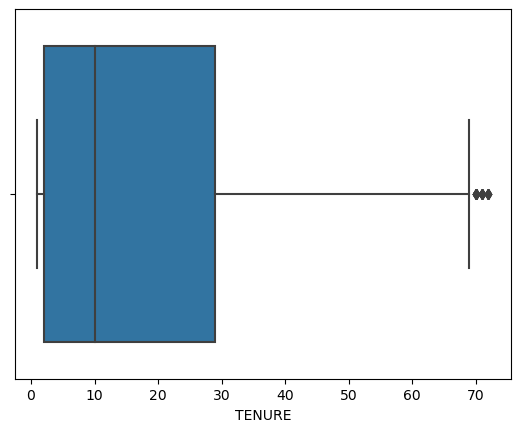

In [22]:
sns.boxplot(x=df.loc[df["CHURN"]==1,"TENURE"])

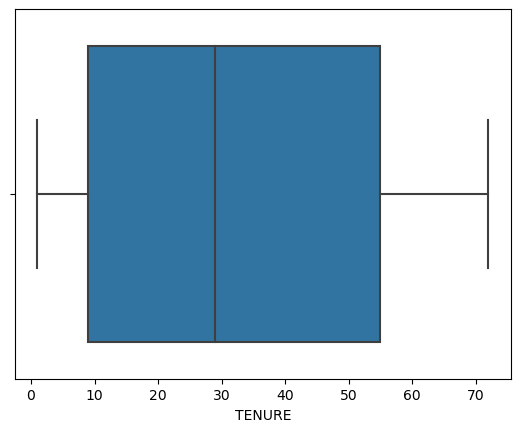

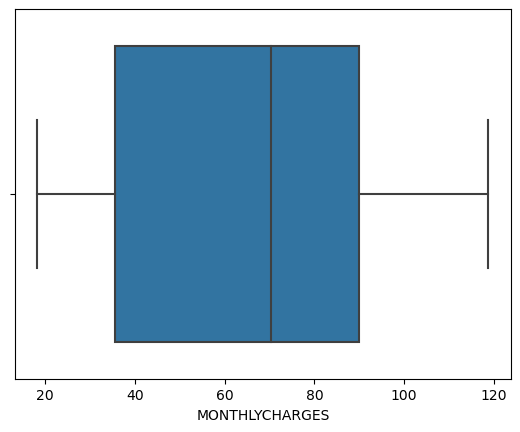

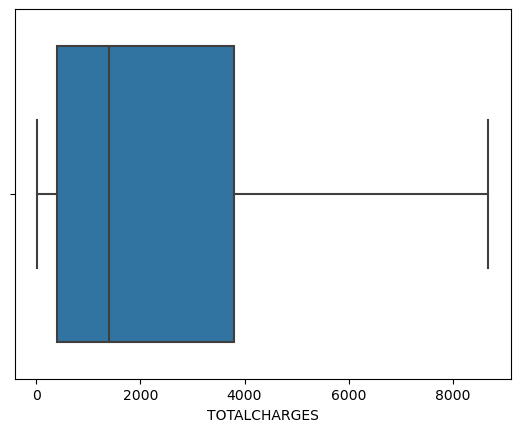

In [23]:
for col in num_cols:
    sns.boxplot(x=df[col], whis = 1.5) 
    plt.show(block = True)

count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
5%          1.000000
10%         2.000000
20%         6.000000
30%        12.000000
40%        20.000000
50%        29.000000
60%        40.000000
70%        50.000000
80%        60.800000
90%        69.000000
95%        72.000000
99%        72.000000
max        72.000000
Name: TENURE, dtype: float64


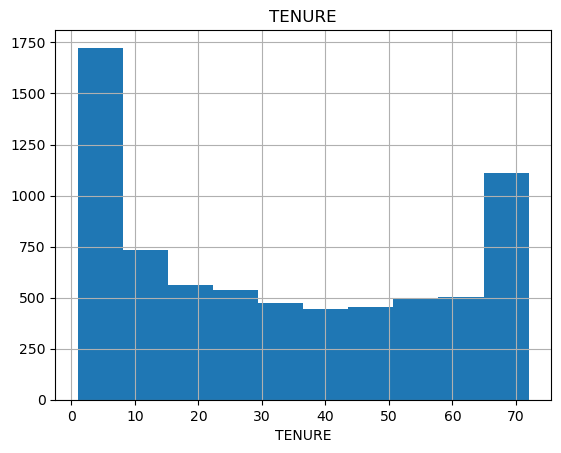

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
5%         19.650000
10%        20.050000
20%        25.050000
30%        45.900000
40%        58.920000
50%        70.350000
60%        79.150000
70%        85.535000
80%        94.300000
90%       102.645000
95%       107.422500
99%       114.734500
max       118.750000
Name: MONTHLYCHARGES, dtype: float64


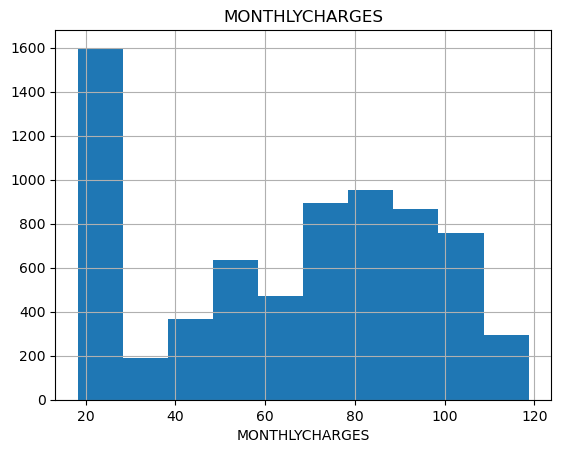

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
5%         49.605000
10%        84.600000
20%       267.070000
30%       551.995000
40%       944.170000
50%      1397.475000
60%      2048.950000
70%      3141.130000
80%      4475.410000
90%      5976.640000
95%      6923.590000
99%      8039.883000
max      8684.800000
Name: TOTALCHARGES, dtype: float64


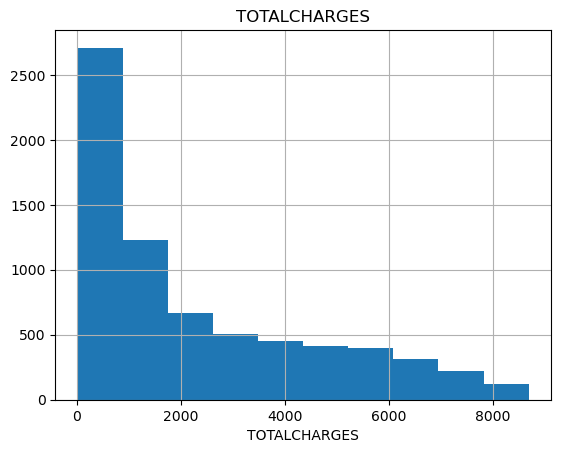

In [24]:
for col in num_cols:
    num_summary(df, col, plot=True)

In [25]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "CHURN", cat_cols)

GENDER : 2
        COUNT     RATIO  TARGET_MEAN
Female   3483  0.495307     0.269595
Male     3549  0.504693     0.262046


PARTNER : 2
     COUNT     RATIO  TARGET_MEAN
No    3639  0.517491     0.329761
Yes   3393  0.482509     0.197171


DEPENDENTS : 2
     COUNT     RATIO  TARGET_MEAN
No    4933  0.701507     0.312791
Yes   2099  0.298493     0.155312


PHONESERVICE : 2
     COUNT     RATIO  TARGET_MEAN
No     680  0.096701     0.250000
Yes   6352  0.903299     0.267475


MULTIPLELINES : 3
                  COUNT     RATIO  TARGET_MEAN
No                 3385  0.481371     0.250812
No phone service    680  0.096701     0.250000
Yes                2967  0.421928     0.286485


INTERNETSERVICE : 3
             COUNT     RATIO  TARGET_MEAN
DSL           2416  0.343572     0.189983
Fiber optic   3096  0.440273     0.418928
No            1520  0.216155     0.074342


ONLINESECURITY : 3
                     COUNT     RATIO  TARGET_MEAN
No                    3497  0.497298     0.417787
No 

# Correlation Map

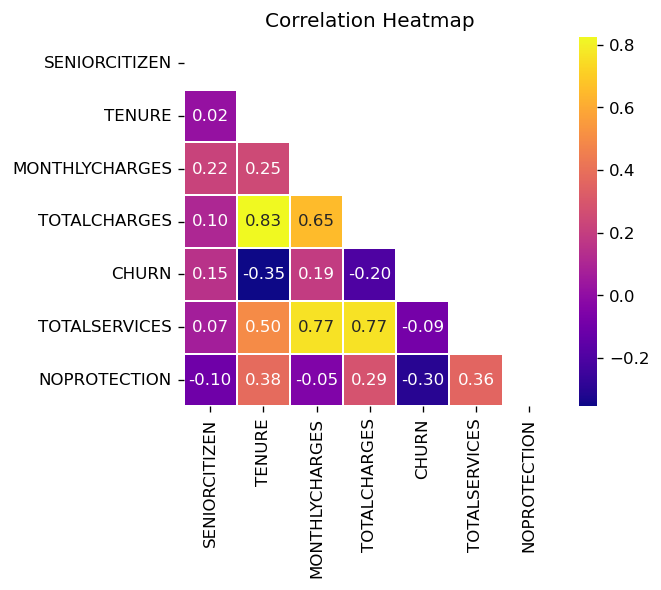

In [26]:
plt.figure(dpi = 120,figsize= (5,4))
mask = np.triu(np.ones_like(df.corr(),dtype = bool))
sns.heatmap(df.corr(),mask = mask, fmt = ".2f",annot=True,lw=1,cmap = 'plasma')
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.title('Correlation Heatmap')
plt.show(block=True)

TENURE ILE TOTALCHARGES ARASINDA YUKSEK KORELASYON OLMASI MANTIKLI CUNKU TENURE YANI TOPLAM HIZMET VERILEN AY ARTTIKCA TAHSIL EDILEN MIKTAR DA ARTAR

In [27]:
def label_encoder(dataframe, binary_col): 
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col]) 
    return dataframe
binary_cols = [col for col in df.columns if df[col].dtype not in ["int64", "float64"] and df[col].nunique() == 2]
for col in binary_cols:
    label_encoder(df, col)
def one_hot_encoder(dataframe, categorical_cols, drop_first=True, dummy_na =False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dummy_na=dummy_na)
    return dataframe
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df = one_hot_encoder(df, ohe_cols)

In [28]:
df.head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,PAPERLESSBILLING,MONTHLYCHARGES,TOTALCHARGES,CHURN,ENGAGED,NOPROTECTION,VIP,SOLO,MULTIPLELINES_No phone service,MULTIPLELINES_Yes,INTERNETSERVICE_Fiber optic,INTERNETSERVICE_No,ONLINESECURITY_No internet service,ONLINESECURITY_Yes,ONLINEBACKUP_No internet service,ONLINEBACKUP_Yes,DEVICEPROTECTION_No internet service,DEVICEPROTECTION_Yes,TECHSUPPORT_No internet service,TECHSUPPORT_Yes,STREAMINGTV_No internet service,STREAMINGTV_Yes,STREAMINGMOVIES_No internet service,STREAMINGMOVIES_Yes,CONTRACT_One year,CONTRACT_Two year,PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check,TOTALSERVICES_1,TOTALSERVICES_2,TOTALSERVICES_3,TOTALSERVICES_4,TOTALSERVICES_5,TOTALSERVICES_6,TOTALSERVICES_7
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
2,1,0,0,0,2,1,1,53.85,108.15,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,0,0,0,45,0,0,42.30,1840.75,0,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


# Feature Scaling

In [29]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [30]:
df.head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,PAPERLESSBILLING,MONTHLYCHARGES,TOTALCHARGES,CHURN,ENGAGED,NOPROTECTION,VIP,SOLO,MULTIPLELINES_No phone service,MULTIPLELINES_Yes,INTERNETSERVICE_Fiber optic,INTERNETSERVICE_No,ONLINESECURITY_No internet service,ONLINESECURITY_Yes,ONLINEBACKUP_No internet service,ONLINEBACKUP_Yes,DEVICEPROTECTION_No internet service,DEVICEPROTECTION_Yes,TECHSUPPORT_No internet service,TECHSUPPORT_Yes,STREAMINGTV_No internet service,STREAMINGTV_Yes,STREAMINGMOVIES_No internet service,STREAMINGMOVIES_Yes,CONTRACT_One year,CONTRACT_Two year,PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check,TOTALSERVICES_1,TOTALSERVICES_2,TOTALSERVICES_3,TOTALSERVICES_4,TOTALSERVICES_5,TOTALSERVICES_6,TOTALSERVICES_7
0,0,0,1,0,-1.280248,0,1,-1.161694,-0.994194,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
1,1,0,0,0,0.064303,1,0,-0.260878,-0.173740,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
2,1,0,0,0,-1.239504,1,1,-0.363923,-0.959649,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,0,0,0,0.512486,0,0,-0.747850,-0.195248,0,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,-1.239504,1,1,0.196178,-0.940457,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [31]:
y = df["CHURN"]
X = df.drop(["CHURN"], axis=1) 

# XGBOOST

In [32]:
xgboost_model = XGBClassifier(random_state=17, use_label_encoder=False)
xgboost_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 17,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [33]:
cv_results = cross_validate(xgboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])


print("Avg. of Accuracy: ", cv_results['test_accuracy'].mean())

print("Avg. of F1 score: ", cv_results['test_f1'].mean())

print("Avg. of AUC-ROC: ", cv_results['test_roc_auc'].mean())

Avg. of Accuracy:  0.7809995945895396
Avg. of F1 score:  0.5507737512482812
Avg. of AUC-ROC:  0.8217573264090416


In [34]:
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100,200],
                  "colsample_bytree": [0.7, 1]}

xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=3, n_jobs=-1, verbose=True).fit(X, y)

xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(xgboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

print(xgboost_best_grid)

print("Avg. of Accuracy: ", cv_results['test_accuracy'].mean())

print("Avg. of F1 score: ", cv_results['test_f1'].mean())

print("Avg. of AUC-ROC: ", cv_results['test_roc_auc'].mean())

Fitting 3 folds for each of 16 candidates, totalling 48 fits
GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=0.7,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.01, max_bin=256,
                                     max_cat_to_onehot=4, max_delta_step=0,
                                     max_depth=5, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                           

In [35]:
xgboost_best_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 200}

## XGBOOST Plot Importance

In [36]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')
    return list(feature_imp.loc[feature_imp["Value"]==0,"Feature"].values)
    


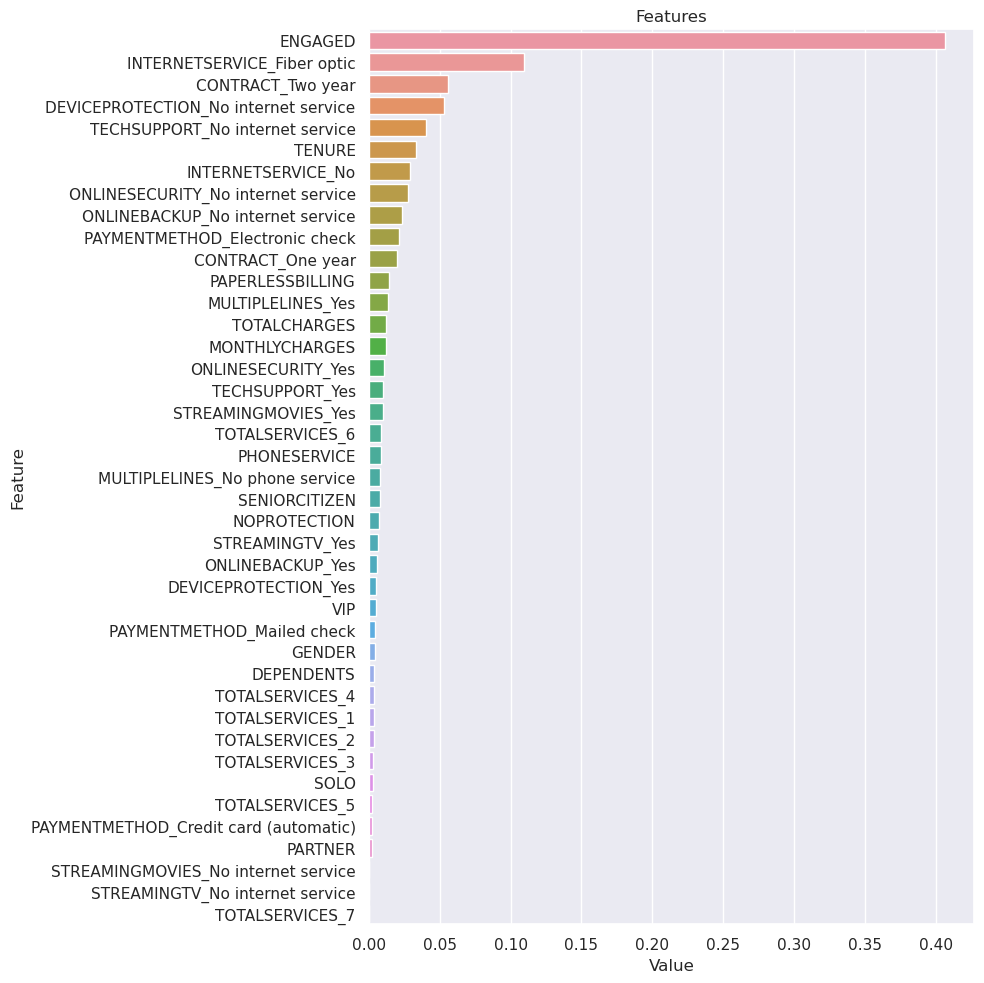

In [37]:
drop_list1 = plot_importance(xgboost_final, X)

# LightGBM

In [38]:
lgbm_model = LGBMClassifier(random_state=17)
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 17,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

boosting_type': 'gbdt' değeri dart da olabilir rf de

In [39]:
cv_results = cross_validate(lgbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])


print("Avg. of Accuracy: ", cv_results['test_accuracy'].mean())

print("Avg. of F1 score: ", cv_results['test_f1'].mean())

print("Avg. of AUC-ROC: ", cv_results['test_roc_auc'].mean())

Avg. of Accuracy:  0.7916666413917003
Avg. of F1 score:  0.5679377836403277
Avg. of AUC-ROC:  0.8323635952314572


In [40]:
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500],
               "colsample_bytree": [0.5, 0.7, 1]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

print("Avg. of Accuracy: ", cv_results['test_accuracy'].mean())

print("Avg. of F1 score: ", cv_results['test_f1'].mean())

print("Avg. of AUC-ROC: ", cv_results['test_roc_auc'].mean())

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Avg. of Accuracy:  0.8019042159654886
Avg. of F1 score:  0.5827672861170514
Avg. of AUC-ROC:  0.8425656976466154


In [41]:
lgbm_best_grid.best_params_

{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 500}

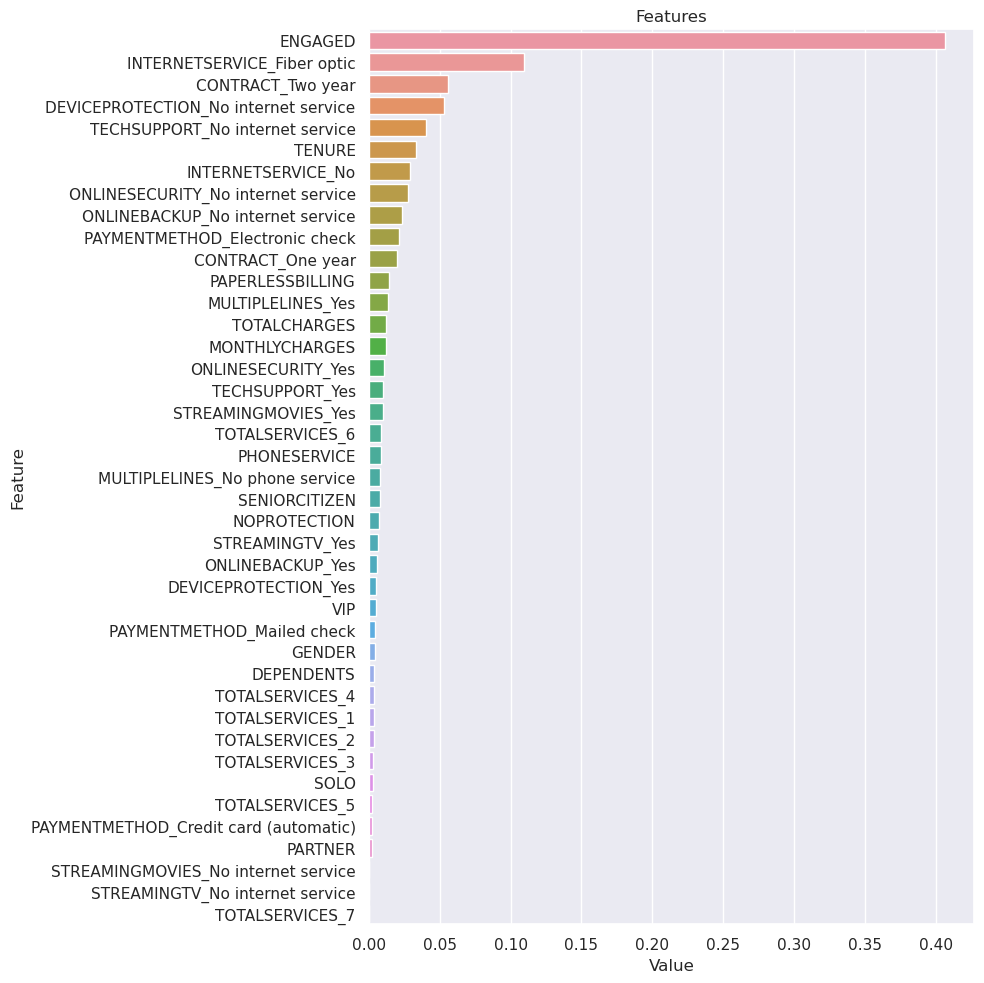

In [42]:
drop_list2 = plot_importance(xgboost_final, X)

In [43]:
drop_list1 == drop_list2

True

In [44]:
df.drop(drop_list1, axis=1, inplace=True)

In [45]:
df.shape

(7032, 39)

F1-score: It is the harmonic mean of precision and recall and provides a balanced evaluation of the model's performance on both positive and negative instances.

AUC-ROC: It measures the trade-off between true positive rate and false positive rate at different classification thresholds and provides an overall assessment of the model's ability to distinguish between positive and negative instances.

In [46]:
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

In [47]:
base_models(X,y)

Base Models....
roc_auc: 0.8445 (LR) 
roc_auc: 0.7808 (KNN) 
roc_auc: 0.6565 (CART) 
roc_auc: 0.8234 (RF) 
roc_auc: 0.8474 (GBM) 
roc_auc: 0.8254 (XGBoost) 
roc_auc: 0.8364 (LightGBM) 
roc_auc: 0.8397 (CatBoost) 


Best 4 are LR, GBM, LightGBM, CatBoost 

In [48]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

# Sample parameters

In [49]:
logreg_params = {'penalty': ['l1', 'l2'],
                 'C': [0.01, 1, 10],
                 'solver': ['lbfgs', 'liblinear'],
                 'max_iter': [100, 500, 1000],
                 'class_weight': ['balanced']}

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [100, 500],
              "subsample": [1, 0.5, 0.7]}

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

classifiers = [('LR', LogisticRegression(), logreg_params),
               ('GBM', GradientBoostingClassifier(), gbm_params),
               ('CatBoost', CatBoostClassifier(verbose=False), catboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

# Hyperparameter Optimization

In [50]:
def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [51]:
 best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimization....
########## LR ##########
roc_auc (Before): 0.8439
roc_auc (After): 0.8423
LR best params: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

########## GBM ##########
roc_auc (Before): 0.8453
roc_auc (After): 0.8453
GBM best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}

########## CatBoost ##########
roc_auc (Before): 0.839
roc_auc (After): 0.8472
CatBoost best params: {'depth': 6, 'iterations': 500, 'learning_rate': 0.01}

########## LightGBM ##########
roc_auc (Before): 0.8327
roc_auc (After): 0.8439
LightGBM best params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 300}



In [52]:
best_models

{'LR': LogisticRegression(C=0.01, class_weight='balanced'),
 'GBM': GradientBoostingClassifier(subsample=1),
 'CatBoost': <catboost.core.CatBoostClassifier at 0x7e3f2bc5e290>,
 'LightGBM': LGBMClassifier(colsample_bytree=0.7, learning_rate=0.01, n_estimators=300)}

# n_estimators parameter optimization only for  LGBM

In [53]:
lgbm_model = LGBMClassifier(random_state=17, colsample_bytree=1, learning_rate=0.01)

lgbm_params = {"n_estimators": [200, 300, 400, 500]} # 5000, 8000, 9000, 10000]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

print("Avg. of Accuracy: ", cv_results['test_accuracy'].mean())

print("Avg. of F1 score: ", cv_results['test_f1'].mean())

print("Avg. of AUC-ROC: ", cv_results['test_roc_auc'].mean())

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Avg. of Accuracy:  0.8007660336804092
Avg. of F1 score:  0.580739967737798
Avg. of AUC-ROC:  0.8411898000559151


In [54]:
lgbm_best_grid.best_params_

{'n_estimators': 400}

In [55]:
# def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
#     train_score, test_score = validation_curve(
#         model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

#     mean_train_score = np.mean(train_score, axis=1)
#     mean_test_score = np.mean(test_score, axis=1)

#     plt.plot(param_range, mean_train_score,
#              label="Training Score", color='b')

#     plt.plot(param_range, mean_test_score,
#              label="Validation Score", color='g')

#     plt.title(f"Validation Curve for {type(model).__name__}")
#     plt.xlabel(f"Number of {param_name}")
#     plt.ylabel(f"{scoring}")
#     plt.tight_layout()
#     plt.legend(loc='best')
#     plt.show(block=True)

# val_curve_params(lgbm_final, X, y, "colsample_bytree", range(0, 3), scoring="roc_auc")

# Oversampling

In [56]:
df = df_.copy()
df.columns = [col.upper() for col in df.columns]

In [57]:
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [58]:
df["TOTALCHARGES"]=pd.to_numeric(df["TOTALCHARGES"], errors="coerce") 
df.dropna(inplace = True)
df.drop('CUSTOMERID', axis=1,inplace=True)

In [59]:
# df["ENGAGED"] = np.where(df['CONTRACT'] != 'Month-to-month', "Yes","No")

# df["TOTALSERVICES"] = (df[["PHONESERVICE", "ONLINESECURITY","ONLINEBACKUP","DEVICEPROTECTION","TECHSUPPORT","STREAMINGTV","STREAMINGMOVIES"]]== 'Yes').sum(axis=1)

# df['NOPROTECTION'] = np.where((df["ONLINEBACKUP"] != 'No') | (df["DEVICEPROTECTION"] != 'No') | (df["TECHSUPPORT"] != 'No'), 1,0)

# df["VIP"] = np.where((df["ENGAGED"]== 'Yes')&(df["TOTALSERVICES"]==7), "Yes","No")

# df["SOLO"] = np.where((df["PARTNER"]== "Yes")&(df["DEPENDENTS"]=="Yes"), "No","Yes")


In [60]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7032
Variables: 20
cat_cols: 17
num_cols: 3
cat_but_car: 0
num_but_cat: 1


In [61]:
def label_encoder(dataframe, binary_col): 
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col]) 
    return dataframe
binary_cols = [col for col in df.columns if df[col].dtype not in ["int64", "float64"] and df[col].nunique() == 2]
for col in binary_cols:
    label_encoder(df, col)
def one_hot_encoder(dataframe, categorical_cols, drop_first=True, dummy_na =False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dummy_na=dummy_na)
    return dataframe
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df = one_hot_encoder(df, ohe_cols)

In [62]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [63]:
df.head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,PAPERLESSBILLING,MONTHLYCHARGES,TOTALCHARGES,CHURN,MULTIPLELINES_No phone service,MULTIPLELINES_Yes,INTERNETSERVICE_Fiber optic,INTERNETSERVICE_No,ONLINESECURITY_No internet service,ONLINESECURITY_Yes,ONLINEBACKUP_No internet service,ONLINEBACKUP_Yes,DEVICEPROTECTION_No internet service,DEVICEPROTECTION_Yes,TECHSUPPORT_No internet service,TECHSUPPORT_Yes,STREAMINGTV_No internet service,STREAMINGTV_Yes,STREAMINGMOVIES_No internet service,STREAMINGMOVIES_Yes,CONTRACT_One year,CONTRACT_Two year,PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check
0,0,0,1,0,-1.280248,0,1,-1.161694,-0.994194,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0.064303,1,0,-0.260878,-0.173740,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,-1.239504,1,1,-0.363923,-0.959649,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0.512486,0,0,-0.747850,-0.195248,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,-1.239504,1,1,0.196178,-0.940457,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [64]:
y = df["CHURN"]
X = df.drop(["CHURN"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=45)

In [65]:
lr_model = LogisticRegression(random_state=17).fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
y_prob = lr_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1552
           1       0.67      0.53      0.59       558

    accuracy                           0.81      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.80      0.81      0.80      2110



In [66]:
roc_auc_score(y_test, y_prob)

0.8444526429072904

SMOTE Oversampling:

"Creating synthetic examples from the minority class to prevent overfitting.

First, a random example is selected from the minority class.
Then, k nearest neighbors are found for this example.
One of the k nearest neighbors is randomly selected and combined with the randomly selected example from the minority class to create a synthetic example by forming a line segment in the feature space."

In [67]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

In [68]:
y_smote.value_counts()

1    3611
0    3611
Name: CHURN, dtype: int64

In [69]:
lr_model = LogisticRegression(random_state=17).fit(X_smote, y_smote)
y_pred = lr_model.predict(X_test)
y_prob = lr_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1552
           1       0.53      0.69      0.60       558

    accuracy                           0.75      2110
   macro avg       0.70      0.73      0.71      2110
weighted avg       0.78      0.75      0.76      2110



In [70]:
roc_auc_score(y_test, y_prob)

0.829582247903041

Random Oversampling:

Random oversampling is a technique that balances the dataset by adding randomly selected examples from the minority class. This technique can be used if your dataset is small. However, it can cause overfitting. The RandomOverSampler method takes the sampling_strategy argument, and when sampling_strategy='minority', it increases the number of the minority class to equal the number of the majority class.

We can enter a float value for this argument. For example, let's say our minority class has 1000 samples and the majority class has 100 samples. If we set sampling_strategy to 0.5, the addition will be made in a way that the number of the minority class will be 500.

In [71]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_randomover, y_randomover = oversample.fit_resample(X_train, y_train)

In [72]:
y_randomover.value_counts()

1    3611
0    3611
Name: CHURN, dtype: int64

In [73]:
lr_model = LogisticRegression(random_state=17).fit(X_randomover, y_randomover)
y_pred = lr_model.predict(X_test)
y_prob = lr_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.74      0.81      1552
           1       0.52      0.79      0.63       558

    accuracy                           0.75      2110
   macro avg       0.71      0.76      0.72      2110
weighted avg       0.80      0.75      0.76      2110



In [74]:
roc_auc_score(y_test, y_prob)

0.8450842709603519